# Addestramento di una U-Net per rilevamento dei difetti su piastrelle magnetiche.

Caricamento del dataset da google drive:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/My Drive/DataSet/DatasetTiles

Mounted at /content/gdrive/
/content/gdrive/My Drive/DataSet/DatasetTiles


## LIbrerie

LIbrerie principali da importare nel progetto:

In [14]:
import os
import time
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchsummary import summary
from torch import autograd, optim
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import cv2 as cv
import glob
import datetime
from tqdm import tqdm

##Costruzione della rete neurale U-Net


Funzioni di utilità della rete:

In [3]:
def get_convolutional_layers(in_channel: int,
                             out_channel: int,
                             kernel_size: tuple = (3, 3),
                             strides: tuple = (1, 1),
                             padding: tuple = (1, 1)):
    r"""
    Convolutional layer.
    :param in_channel: number of input filters.
    :param out_channel: number of output filters.
    :param kernel_size: kernel size.
    :param strides: stride size.
    :param padding: padding size.
    """

    return nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=strides,
                     padding=padding)


def get_relu():
    r"""
    Relu activation function.
    """
    return nn.ReLU(inplace=True)


def get_sigmoid():
    r"""
    Sigmoid activation function.
    """
    return nn.Sigmoid()


def get_max_pooling(kernel_size: tuple = (2, 2),
                    strides: tuple = (2, 2)):
    r"""
    Max pooling layer.
    :param kernel_size: kernel size.
    :param strides: stride size.
    """
    return nn.MaxPool2d(kernel_size=kernel_size, stride=strides)


def get_up_sample(scale_factor: int = 2):
    r"""
    Up sample layer.
    :param scale_factor: scale factor.
    """
    return nn.Upsample(scale_factor=scale_factor)

### Blocchi della rete

Blocco di down-sampling, bottleneck, blocco di up-sampling e di output:

In [4]:
class Down(nn.Module):
    r"""
    Downsampling block.
    """

    def __init__(self,
                 in_channel: int,
                 out_channel: int):
        r"""
        :param in_channel: number of input filters.
        :param out_channel: number of output filters.
        """
        super().__init__()

        self.conv_1 = get_convolutional_layers(in_channel, out_channel)
        self.conv_2 = get_convolutional_layers(out_channel, out_channel)
        self.activation = get_relu()
        self.max_pooling = get_max_pooling()

    def forward(self, x):
        r"""
        Forward down block.
        """
        out_conv = self.conv_1(x)
        out_relu = self.activation(out_conv)

        out_conv = self.conv_2(out_relu)
        out_relu = self.activation(out_conv)

        out_pooling = self.max_pooling(out_relu)
        return out_relu, out_pooling


class Bottleneck(nn.Module):
    r"""
    Bottleneck block.
    """

    def __init__(self,
                 in_channel: int,
                 out_channel: int):
        r"""

        :param in_channel: number of input filters.
        :param out_channel: number of output filters.
        """
        super().__init__()

        self.conv_1 = get_convolutional_layers(in_channel, out_channel)
        self.conv_2 = get_convolutional_layers(out_channel, out_channel)
        self.activation = get_relu()

    def forward(self, x):
        r"""
        Forward bottleneck block.
        """
        out_conv = self.conv_1(x)
        out_relu = self.activation(out_conv)

        out_conv = self.conv_2(out_relu)
        out_relu = self.activation(out_conv)

        return out_relu


class Up(nn.Module):
    r"""
    Upsampling block.
    """

    def __init__(self,
                 in_channel: int,
                 out_channel: int):
        r"""
        :param in_channel: number of input filters.
        :param out_channel: number of output filters.
        """
        super().__init__()

        self.up_sample = get_up_sample()
        self.concat = Concat()
        self.activation = get_relu()
        self.conv_1 = get_convolutional_layers(in_channel=in_channel, out_channel=out_channel)
        self.conv_2 = get_convolutional_layers(out_channel, out_channel)

    def forward(self, x, skip):
        r"""
        Forward upblock.
        :param x: input layer.
        :param skip: skip connection layer to concatenate.
        """
        out_up = self.up_sample(x)
        out_concat = self.concat(out_up, skip)
        out_conv = self.conv_1(out_concat)
        out_relu = self.activation(out_conv)
        out_conv = self.conv_2(out_relu)
        out_relu = self.activation(out_conv)

        return out_relu


class Concat(nn.Module):
    r"""
    Concatenate class.
    Concatenate two levels of the network.
    """

    def __init__(self):
        super().__init__()

    def forward(self, layer_1, layer_2):
        out_concat = torch.cat((layer_1, layer_2), dim=1)
        return out_concat


class Out(nn.Module):
    r"""
    Output block.
    """

    def __init__(self,
                 in_channel: int,
                 out_channel: int,
                 kernel_size: tuple):
        r"""
        :param in_channel: number of input filters.
        :param out_channel: number of output filters.
        :param kernel_size: kernel size.
        """
        super().__init__()

        self.conv = get_convolutional_layers(in_channel=in_channel, out_channel=out_channel, kernel_size=kernel_size,
                                             padding=(0, 0))
        self.sigmoid = get_sigmoid()

    def forward(self, x: torch.Tensor):
        r"""
        Forward output block.
        """
        out_conv = self.conv(x)
        out_sigmoid = self.sigmoid(out_conv)

        return out_sigmoid

### Corpo della rete

In [5]:
def get_model(num_classes):
    """
    Get the model.
    :param num_classes: number of classes.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Unet(n_classes_out=num_classes)
    model = model.to(device)

    return model

class Unet(nn.Module):
    r"""
    U-net class.
    """

    def __init__(self,
                 n_classes_out: int,
                 block_filter_count = [3, 64, 128, 256, 512, 1024]):
        r"""
        Builder of the class.
        :param n_classes_out: number of classes of the problem.
        :param block_filter_count: number of filters for each convolutional layer.
        """
        super(Unet, self).__init__()

        self.blocks_down = []
        self.blocks_up = []

        # Down sampling path
        print("** Block downs **")
        for i in range(0, 4):
            block = Down(in_channel=block_filter_count[i], out_channel=block_filter_count[i + 1])
            print(f"Block down {i + 1}-layer: in: {block_filter_count[i]}, out: {block_filter_count[i + 1]}")
            self.blocks_down.append(block)

        # Bottleneck
        print("\n** Bottleneck **")
        self.bottleneck = Bottleneck(in_channel=block_filter_count[4], out_channel=block_filter_count[5])
        print(f"Bottleneck layer: in: {block_filter_count[4]}, out: {block_filter_count[5]}")

        # Up sampling path
        print("\n** Block ups **")
        for i in range(0, 4):
            block = Up(in_channel=block_filter_count[5 - i] + block_filter_count[5 - (i + 1)],
                             out_channel=block_filter_count[5 - (i + 1)])
            print(
                f"Block ups {i + 1}-layer: in: {block_filter_count[5 - i] + block_filter_count[5 - (i + 1)]}, out: {block_filter_count[5 - (i + 1)]}")
            self.blocks_up.append(block)

        # Output layer
        print("\n** Out net **")

        self.out = Out(in_channel=block_filter_count[1], out_channel=n_classes_out, kernel_size=(1, 1))
        print(f"Out layer: in: {block_filter_count[1]}, out: {n_classes_out}\n")

        self.blocks_down = nn.ModuleList(self.blocks_down)
        self.bottleneck = nn.ModuleList([self.bottleneck])
        self.blocks_up = nn.ModuleList(self.blocks_up)

    def forward(self, x: torch.Tensor):
        r"""
        Forward of the network.
        :param x: input net.
        :return: output net.
        """

        encoder = []

        # Down sampling path
        for block in self.blocks_down:
            out_conv, out_pool = block(x)

            encoder.append(out_conv)
            x = out_pool

        out_down_blocks = x

        # Bottleneck
        bn = self.bottleneck[0](out_down_blocks)
        x = bn

        # Up sampling path
        for index, block in enumerate(self.blocks_up):
            x = block(x, encoder[len(encoder) - (index + 1)])

        # Output layer
        out_net = self.out(x)

        return out_net


## Metriche

Metriche per valutare i risultati della rete:

In [6]:
def numeric_score(prediction, target):
    r"""
    Calculation prediction.
    """

    prediction[prediction > 0.9] = 1
    prediction[prediction <= 0.9] = 0

    false_positive = np.float(np.sum((prediction == 1) & (target == 0)))
    false_negative = np.float(np.sum((prediction == 0) & (target == 1)))
    true_positive = np.float(np.sum((prediction == 1) & (target == 1)))
    true_negative = np.float(np.sum((prediction == 0) & (target == 0)))

    return false_positive, false_negative, true_positive, true_negative


def get_accuracy(prediction, target):
    r"""
    Calculation of accuracy.
    :param target: tagret input.
    :param prediction: predicted input.
    :return: system accuracy.
    """

    false_positive, false_negative, true_positive, true_negative = numeric_score(prediction, target)
    total_prediction = false_positive + false_negative + true_positive + true_negative
    acc = np.divide(true_positive + true_negative, total_prediction) * 100

    return acc


def get_IoU(prediction, target, smooth=1e-12):
    r"""
    Calculation of IoU.
    :param target: target input.
    :param prediction: predicted input.
    :param smooth: infinitesimal quantity to avoid division by 0.
    """
    if target.shape != prediction.shape:
        raise Exception("Input target has dimension ", target.shape, ". Predicted values have shape", prediction.shape)

    if len(target.shape) != 4:
        raise Exception("Input target has dimension ", target.shape, ". Must be 4.")

    prediction[prediction > 0.9] = 1
    prediction[prediction <= 0.9] = 0

    intersection = (prediction * target).sum()  # Logical AND
    union = (prediction + target).sum()  # Logical OR
    union = union - intersection
    IoU_score = (intersection + smooth) / (union + smooth)

    return IoU_score

## Early Stopping

Classe Early stopping implementata per evitare l'over fitting.

In [7]:
class EarlyStopping:
    r"""
    Class that implements early stopping to end network training to avoid the overfitting.
    """

    def __init__(self, patience=5):
        r"""
        Constructor of class.
        :param patience: number of epochs to wait to finish the training.
        """
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):

        if self.best_loss is None or val_loss < self.best_loss:

            if self.counter > 0:
                print("[EARLY STOPPING] --> Reset counter")

            # Update the best loss field
            self.best_loss = val_loss
            self.counter = 0

        elif val_loss == self.best_loss:

            if self.counter > 0:
                print("[EARLY STOPPING] --> Reset counter")
            self.counter = 0

        elif val_loss > self.best_loss:

            self.counter += 1
            print(f"[EARLY STOPPING] --> Counter {self.counter} of {self.patience}")

            if self.counter == self.patience:
                print('[EARLY STOPPING] --> Stop training')
                self.early_stop = True

## Dataset

Classe per caricamento del dataset nella rete con successiva pre-elaborazione delle immagini:

In [8]:
class DatasetTiles(Dataset):
    r"""
    Class to load the dataset of a specific defect.
    """

    def __init__(self, parent_dir, defect, width=256, height=256):
        r"""
        Load the dataset.
        :param parent_dir: root folder.
        :param defect: directory of the defect.

        Image format:
            - .jpg: image
            - .png: binay mask
        """
        self.img_list_path = glob.glob(parent_dir + '/' + defect + '/Imgs/*.jpg')
        self.img_mask_list_path = glob.glob(parent_dir + '/' + defect + '/Imgs/*.png')

        self.img_list_path.sort()
        self.img_mask_list_path.sort()

        self.width = width
        self.height = height

        print(f"{defect} loaded!")

    def __getitem__(self, index):
        r"""
        Get the image and its mask
        :param index: index of the specific image
        """

        x = self.preprocessing(self.img_list_path[index], False)
        # Resize input format [height, width, n_channels]
        x = np.rollaxis(x, 2, 0)

        y = self.preprocessing(self.img_mask_list_path[index], True)
        # Add 1 channel to input. Input format [height, width, n_channels]
        y = np.expand_dims(y, axis=0)

        return x, y

    def preprocessing(self, img, convert_to_gray):
        r"""
        Performs a preprocessing on the image.
        :param img: img to be processed
        :param convert_to_gray: true if the conversion is grayscale, false otherwise.
        """

        img = cv.imread(img)
        img = cv.resize(img, (self.width, self.height))

        if convert_to_gray:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        else:
            img = cv.cvtColor(img, cv.COLOR_RGB2BGR)

        img = img / 255
        img = img.astype(np.float32)

        return img

    def __len__(self):
        return len(self.img_list_path)


def train_test_split(dataset):
    r"""
    Slip dataset in training, validation and test set:
        - 70% training set;
        - 20% validation set:
        - 10% test set.

    :param dataset: dataset to split
    :return : training, validation and test set.
    """
    length_dataset = len(dataset)

    length_train = np.int_(length_dataset * 0.7)
    length_validate = np.int_(length_dataset * 0.2)

    training_dataset = Subset(dataset, range(0, length_train))
    validation_dataset = Subset(dataset, range(length_train, length_train + length_validate))
    test_dataset = Subset(dataset, range(length_train + length_validate, len(dataset)))

    return training_dataset, validation_dataset, test_dataset


## Grafici

Vengono definite funzioni di utilità per mostrare i dati sull'adddestramento e i risultati ottenuti.

In [23]:
def plot_history(loss_train, loss_valid, accuracy_valid, IoU_valid, num_epochs):
    r"""
    Shows the results obtained.
    :param loss_train: loss obtained from the training data
    :param loss_valid: loss obtained from the validation data
    :param accuracy_valid: accuracy obtained
    :param IoU_valid: intersection over union obtained
    :param num_epochs: number of epochs
    """

    plt.plot(range(1, num_epochs), loss_train, color='r', label='Training Loss')
    plt.plot(range(1, num_epochs), loss_valid, color='g', label='Validation Loss')
    plt.xlabel('Epoch number')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.title('Loss history')
    plt.show()

    plt.plot(range(1, num_epochs), accuracy_valid, color='r', label='Accuracy')
    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.title('Accuracy history')
    plt.show()

    plt.plot(range(1, num_epochs), IoU_valid, color='r', label="IoU")
    plt.xlabel('Epoch number')
    plt.ylabel('IoU')
    plt.legend(loc='upper right')
    plt.title('IoU history')
    plt.show()

def plot_test_results(images, masks, predicted, rows=4):
    r"""
    PLot test results.
    :param images: collection of images of the dataset.
    :param masks: collection of masks of the dataset.
    :param predicted: images predicted by the network.
    :param rows: row table.
    """

    if rows >= len(images):
        raise Exception("The rows table must be less than the number of images!")

    images_copy = images.copy()
    masks_copy = masks.copy()
    predicted_copy = predicted.copy()

    fig, axs = plt.subplots(rows, 3, figsize=(32, 16))
    axs = axs.ravel()

    counter = 0

    for i in range(rows):
        index = random.randint(0, len(images_copy) - 1)
        img = images_copy[index]
        mask = masks_copy[index]
        predict = predicted_copy[index]

        img = img.permute(1, 2, 0).cpu().numpy()

        mask = mask.permute(1, 2, 0).cpu().numpy()
        mask = mask[:, :, 0]

        predict = predict.permute(1, 2, 0).cpu().numpy()
        predict = predict[:, :, 0]

        del images_copy[index]
        del masks_copy[index]
        del predicted_copy[index]

        axs[i + counter].imshow(img)
        axs[i + 1 + counter].imshow(mask)
        axs[i + 2 + counter].imshow(predict, cmap="gray")

        counter += 2

    plt.show()

## **Training**

Funzioni per implementare l'addestramento della rete.

In [16]:
SHOW_EVERY = 1
PARENT_DIR = "/content/gdrive/MyDrive/DataSet/DatasetTiles/ModelSaved"


def _round(values, decimal=3):
    return round(values, decimal)


def training_loop(model, num_epochs, optimizer, lr_scheduler, loss_fn, training_loader, validation_loader, directory):
    r"""
    Network training.
    :param model: neural network model.
    :param num_epochs: number of epochs.
    :param optimizer: optimize used.
    :param lr_scheduler: scheduler used.
    :param loss_fn: loss function used.
    :param training_loader: training data.
    :param validation_loader: validation data.
    :param directory: name directory.
    """

    print("\n** Training **\n")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    folder = create_directory(directory)
    with open(PARENT_DIR + "/" + directory + '/log/log.txt', 'w') as f:
        f.write(
            f'Training:\nEpochs: {num_epochs},\nOptimizer: {optimizer.__class__.__name__},\n'
            f'Loss: {loss_fn.__class__.__name__},\nLearning Rate: {optimizer.defaults["lr"]}')

    ## Initialized parameters before training ##

    # Loss
    training_loss_arr = []
    validation_loss_arr = []

    # Accuracy
    training_accuracy_arr = []
    validation_accuracy_arr = []

    # Intersection over Union (IoU)
    training_IoU_arr = []
    validation_IoU_arr = []

    # Parameters to plot loss and accuracy
    plot_train_loss = []
    plot_validate_loss = []
    plot_validate_accuracy = []
    plot_validate_IoU = []

    # Early stopping
    early_stopping = EarlyStopping()

    last_epoch = 1
    for epoch in range(1, num_epochs + 1):

        # Train model
        loss, accuracy, IoU = train_one_epoch(model, training_loader, optimizer, loss_fn, epoch, num_epochs, device)

        # Update parameters
        training_loss_arr.append(loss)
        training_accuracy_arr.append(accuracy)
        training_IoU_arr.append(IoU)
        plot_train_loss.append(loss)

        # Evaluate model
        loss, accuracy, IoU = evaluate(model, validation_loader, loss_fn, epoch, num_epochs, device)

        # Update parameters
        validation_loss_arr.append(loss)
        validation_accuracy_arr.append(accuracy)
        validation_IoU_arr.append(IoU)

        plot_validate_loss.append(loss)
        plot_validate_accuracy.append(accuracy)
        plot_validate_IoU.append(IoU)

        if lr_scheduler is not None:
            last_lr = lr_scheduler.get_last_lr()
        else:
            last_lr = optimizer.defaults['lr']

        print(
            f"\n############### Epoch: {epoch}, Train Loss: {_round(training_loss_arr[-1])}, Learning rate: {last_lr},"
            f" Train Acc: {_round(training_accuracy_arr[-1])}, Train IOU: {_round(training_IoU_arr[-1])} ###############")

        print(
            f"############### Epoch: {epoch}, Valid Loss: {_round(validation_loss_arr[-1])}, Learning rate: {last_lr},"
            f" Valid Acc: {_round(validation_accuracy_arr[-1])}, Valid IOU: {_round(validation_IoU_arr[-1])} ###############")

        if epoch % 10 == 0:
            # Log training
            with open(PARENT_DIR + "/" + directory + '/log/log.txt', 'a') as f:
                f.write(
                    f"\n############### Epoch: {epoch}, Train Loss: {_round(training_loss_arr[-1])}, Learning rate: {last_lr},"
                    f" Train Acc: {_round(training_accuracy_arr[-1])}, Train IOU: {_round(training_IoU_arr[-1])} ###############"
                    f"\n############### Epoch: {epoch}, Valid Loss: {_round(validation_loss_arr[-1])}, Learning rate: {last_lr},"
                    f" Valid Acc: {_round(validation_accuracy_arr[-1])}, Valid IOU: {_round(validation_IoU_arr[-1])} ###############\n"
                )

            # Save model each n epochs
            save_model(model, epoch, optimizer, training_loss_arr, validation_loss_arr, training_accuracy_arr,
                       validation_accuracy_arr, folder, f"model_epoch_{epoch}.pth")

        last_epoch += 1
        # Early Stopping
        early_stopping(np.round(validation_loss_arr[-1], 4))
        if early_stopping.early_stop or epoch == num_epochs - 1:
            save_model(model, epoch, optimizer, training_loss_arr, validation_loss_arr, training_accuracy_arr,
                       validation_accuracy_arr, folder, f"best_model_{epoch}.pth")

            # Stop training
            break

        if lr_scheduler is not None:
            lr_scheduler.step()

    return plot_train_loss, plot_validate_loss, plot_validate_accuracy, plot_validate_IoU, last_epoch


def train_one_epoch(model, training_loader, optimizer, loss_fn, currennt_epoch, num_epochs, device):
    """
    Train model for each epoch.
    """

    model.train()

    training_loss_batch = []
    training_accuracy_batch = []
    training_IoU_batch = []

    # Training Loop
    train_bar = tqdm(training_loader, total=len(training_loader))

    for X, y in train_bar:
        X = X.to(device)
        y = y.to(device)
        y[y > 0] = 1

        optimizer.zero_grad()

        # Forward pass
        y_predicted = model(X)

        loss = loss_fn(y_predicted, y)
        loss_value = loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

        accuracy_value = get_accuracy(y_predicted.cpu().detach().numpy(), y.cpu().detach().numpy())

        IoU_value = get_IoU(y_predicted.cpu().detach().numpy(), y.cpu().detach().numpy())

        # Added Loss
        training_loss_batch.append(loss_value)

        # Added accuracy
        training_accuracy_batch.append(accuracy_value)

        # Added IoU
        training_IoU_batch.append(IoU_value)

        train_bar.set_description(
            f"Epoch: {currennt_epoch}/{num_epochs}, Train Loss: {_round(loss_value, 5)}, Train accuracy: {_round(accuracy_value, 5)}, Train IoU:{_round(IoU_value, 5)}")

    return np.mean(training_loss_batch), np.mean(training_accuracy_batch), np.mean(training_IoU_batch)


def evaluate(model, validation_loader, loss_fn, currennt_epoch, num_epochs, device):
    """
    Evaluate model for each epoch.
    """
    model.eval()

    validation_loss_batch = []
    validation_accuracy_batch = []
    validation_IoU_batch = []

    # Validation loop
    valid_bar = tqdm(validation_loader, total=len(validation_loader))

    # No grad in validation
    with torch.no_grad():
        for X, y in valid_bar:
            X = X.to(device)
            y = y.to(device)
            y[y > 0] = 1

            y_predicted = model(X)
            loss = loss_fn(y_predicted, y)
            loss_value = loss.item()

            accuracy_value = get_accuracy(y_predicted.cpu().detach().numpy(), y.cpu().detach().numpy())

            IoU_value = get_IoU(y_predicted.cpu().detach().numpy(), y.cpu().detach().numpy())

            # Added Loss
            validation_loss_batch.append(loss_value)

            # Added accuracy
            validation_accuracy_batch.append(accuracy_value)

            # Added IoU
            validation_IoU_batch.append(IoU_value)

            valid_bar.set_description(
                f"Epoch: {currennt_epoch}/{num_epochs}, Valid loss: {_round(loss_value, 5)}, Valid accuracy: {_round(accuracy_value, 5)}, Valid IoU:{_round(IoU_value, 5)}")

    return np.mean(validation_loss_batch), np.mean(validation_accuracy_batch), np.mean(validation_IoU_batch)


def testing_net(test_loader, model, loss_fn):
    r"""
    Show test results of the neural network.
    :param test_loader: test data.
    :param model: net model.
    :param loss_fn: loss function used.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_loss_arr = []
    test_accuracy_arr = []
    test_IoU_arr = []

    # Parameters to plot the results
    plot_img = []
    plot_mask = []
    plot_predicted = []

    model.eval()

    # Test loop
    with torch.no_grad():
        # Test steps
        test_loss_batch = []
        test_accuracy_batch = []
        test_IoU_batch = []

        test_bar = tqdm(test_loader, total=len(test_loader))

        for X, y in test_bar:
            X = X.to(device)
            y = y.to(device)
            y[y > 0] = 1

            y_predicted = model(X)

            for i, image in enumerate(X):
                plot_img.append(image)
                plot_mask.append(y[i])
                plot_predicted.append(y_predicted[i])

            loss = loss_fn(y_predicted, y)
            loss_value = loss.item()
            accuracy_value = get_accuracy(y_predicted.cpu().detach().numpy(), y.cpu().detach().numpy())
            IoU_value = get_IoU(y_predicted.cpu().detach().numpy(), y.cpu().detach().numpy())

            # Added Loss
            test_loss_batch.append(loss_value)

            # Added Accuracy
            test_accuracy_batch.append(accuracy_value)

            # Added IoU
            test_IoU_batch.append(IoU_value)

        test_loss_arr.append(np.mean(test_loss_batch))
        test_accuracy_arr.append(np.mean(test_accuracy_batch))
        test_IoU_arr.append(np.mean(test_IoU_batch))

        print(
            f"\n############### Test Loss: {test_loss_arr[-1]}, Test Acc: {test_accuracy_arr[-1]}, Test "
            f"IOU: {test_IoU_arr[-1]} ###############")

    return plot_img, plot_mask, plot_predicted


def save_model(model, epoch, optimizer, training_loss, validation_loss, training_acc, validation_acc, new_dir,
               name_file):
    r"""
    Save the model.
    :param model: model to saved.
    :param epoch: current epoch.
    :param optimizer: net optimizer.
    :param training_loss: training loss.
    :param training_acc: training accuracy.
    :param validation_loss: validation loss.
    :param validation_acc: validation accuracy.
    :param new_dir: new directory created.
    :param name_file: name file to be saved. (Extension file .pth)
    """

    checkpoint = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'Training Loss': np.mean(training_loss),
        'Validation Loss': np.mean(validation_loss),
        'Training Accuracy': np.mean(training_acc),
        'Validation Accuracy': np.mean(validation_acc),
        "directory": new_dir
    }

    torch.save(checkpoint, PARENT_DIR + "/" + new_dir + "/" + name_file)
    print(f"[{epoch + 1}] Model saved!\n")


def load_model(model, optimizer, path):
    """
    Load model.

    :param model: model net.
    :param optimizer: optimizer.
    :param path: path to load model.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if device == "cuda":
        file = torch.load(path)
    else:
        file = torch.load(path, map_location='cpu')

    model.state_dict(file['state_dict'])
    optimizer.load_state_dict(file['optimizer_state_dict'])
    epochs = file['epoch']
    directory = file['directory']

    return model, optimizer, epochs


def create_directory(new_dir):
    r"""
    Create directory for saved model.

    :param new_dir: name directory.
    """

    try:
        os.mkdir(PARENT_DIR)
    except:
        pass

    path = PARENT_DIR + "/" + new_dir
    os.mkdir(path)
    os.mkdir(path + "/log")

    open(path + "/log/log.txt", "x")
    print("Directory and file created!\n")

    return new_dir



Costruzione della rete, caricamento del dataset, setting degli iperparametri, training della rete:

In [11]:
SHOW_SAMPLES_TRAIN = True
SHOW_SUMMARY = True
TRAIN_NET = True

PARENT_MODELS_DIR = "/content/gdrive/MyDrive/DataSet/DatasetTiles/ModelSaved"
PARENT_DATASET_DIR = "/content/gdrive/MyDrive/DataSet/DatasetTiles/"
BLOWHOLE = "MT_Blowhole"
CRACK = "MT_Crack"
FREE = "MT_Free"
defects = [BLOWHOLE, CRACK, FREE]
datasets = []
train_arr = []
valid_arr = []
test_arr = []

num_classes = 1

# Loaded dataset
print("Loading dataset in progress ...")
for defect in defects:
    # Load each type of defect
    datasets.append(DatasetTiles(PARENT_DATASET_DIR, defect))

for dataset in datasets:
    # Split each dataset in train, validation and test set
    training_dataset, validation_dataset, test_dataset = train_test_split(dataset)

    train_arr.append(training_dataset)
    valid_arr.append(validation_dataset)
    test_arr.append(test_dataset)

# Concatenate all datasets loaded
training_dataset, validation_dataset, test_dataset = ConcatDataset(train_arr), ConcatDataset(valid_arr), \
                                                     ConcatDataset(test_arr)

print(f"** Dataset loaded correctly! Imgs: {len(training_dataset) + len(validation_dataset) + len(test_dataset)} **\n")
print(f"Size train: {len(training_dataset)} - 70%")
print(f"Size validation: {len(validation_dataset)} - 20%")
print(f"Size test: {len(test_dataset)} - 10%")
print(f"Total imgs splitted: {len(training_dataset) + len(validation_dataset) + len(test_dataset)}\n\n")

batch_size = 4

# Training set
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=False)

# Validation set
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Loading dataset in progress ...
MT_Blowhole loaded!
** Dataset loaded correctly! Imgs: 115 **

Size train: 80 - 70%
Size validation: 23 - 20%
Size test: 12 - 10%
Total imgs splitted: 115




Esempio di alcune immagini del training set.

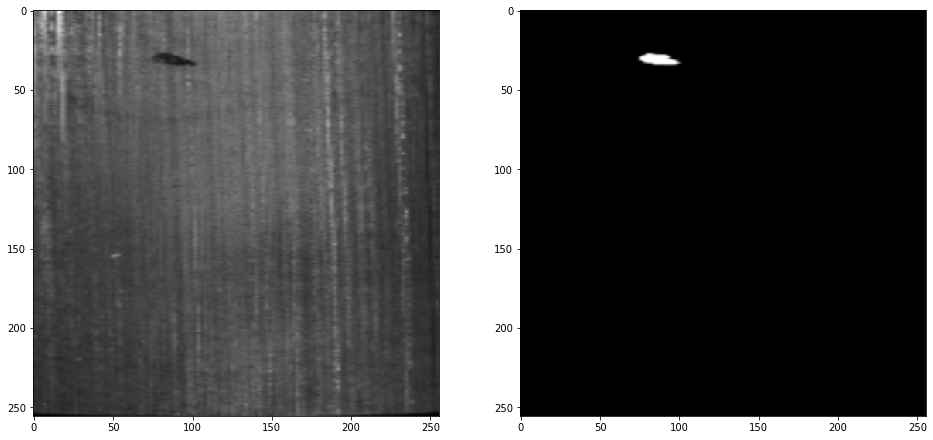

In [12]:
def plot_samples(index, img, label):
    r"""
    Plot examples of the dataset.
    :param index: index of the array
    :param img: img to plot
    :param label: label to plot
    """

    sample_image = img[index]
    sample_label = label[index]

    img = np.squeeze(sample_image)
    img = img[0, :, :]
    plt.title('Image')
    plt.imshow(img, cmap="gray")
    plt.show()

    label = np.squeeze(sample_label)
    plt.title('Label')
    plt.imshow(label, cmap="gray")
    plt.show()

def sample_dataset(training_dataset):
    r"""
    Shows an example of the training dataset
    :param training_dataset: dataset.
    """
    
    for label in training_dataset:
        fig, axs = plt.subplots(1, 2, figsize=(16, 8))

        random_seed = random.randint(0, len(label) - 1)
        x, y = label[random_seed]

        x = x[0, :, :]
        axs[0].imshow(x, cmap='gray')

        y = y[0, :, :]
        axs[1].imshow(y, cmap='gray')

        plt.show()

# Show samples train dataset
if SHOW_SAMPLES_TRAIN:
    sample_dataset(train_arr)

Addestramento della rete

** Block downs **
Block down 1-layer: in: 3, out: 64
Block down 2-layer: in: 64, out: 128
Block down 3-layer: in: 128, out: 256
Block down 4-layer: in: 256, out: 512

** Bottleneck **
Bottleneck layer: in: 512, out: 1024

** Block ups **
Block ups 1-layer: in: 1536, out: 512
Block ups 2-layer: in: 768, out: 256
Block ups 3-layer: in: 384, out: 128
Block ups 4-layer: in: 192, out: 64

** Out net **
Out layer: in: 64, out: 1

Shape out net: torch.Size([1, 1, 256, 256]) 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
              Down-6  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0

Epoch: 1/1, Train Loss: 0.63546, Train accuracy: 99.85809, Train IoU:0.0: 100%|██████████| 20/20 [02:00<00:00,  6.01s/it]
Epoch: 1/1, Valid loss: 0.63292, Valid accuracy: 99.86064, Valid IoU:0.0: 100%|██████████| 6/6 [00:32<00:00,  5.47s/it]


############### Epoch: 1, Train Loss: 0.655, Learning rate: [0.001], Train Acc: 99.727, Train IOU: 0.0 ###############
############### Epoch: 1, Valid Loss: 0.633, Learning rate: [0.001], Valid Acc: 99.738, Valid IOU: 0.0 ###############
** Training time: 2.551 minutes **




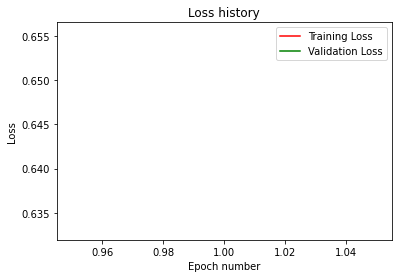

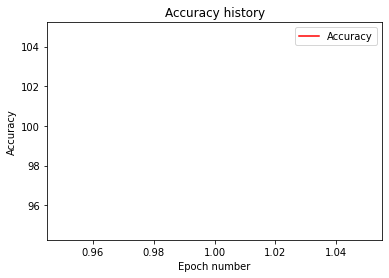

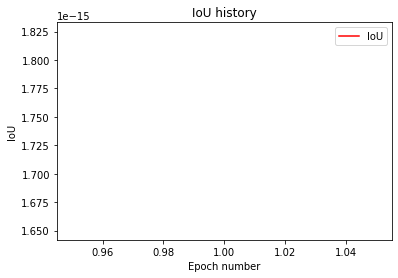

100%|██████████| 3/3 [00:16<00:00,  5.59s/it]



############### Test Loss: 0.6330932776133219, Test Acc: 99.66672261555989, Test IOU: 1.1535919230575055e-15 ###############
Error: Invalid shape (256, 256, 1) for image data


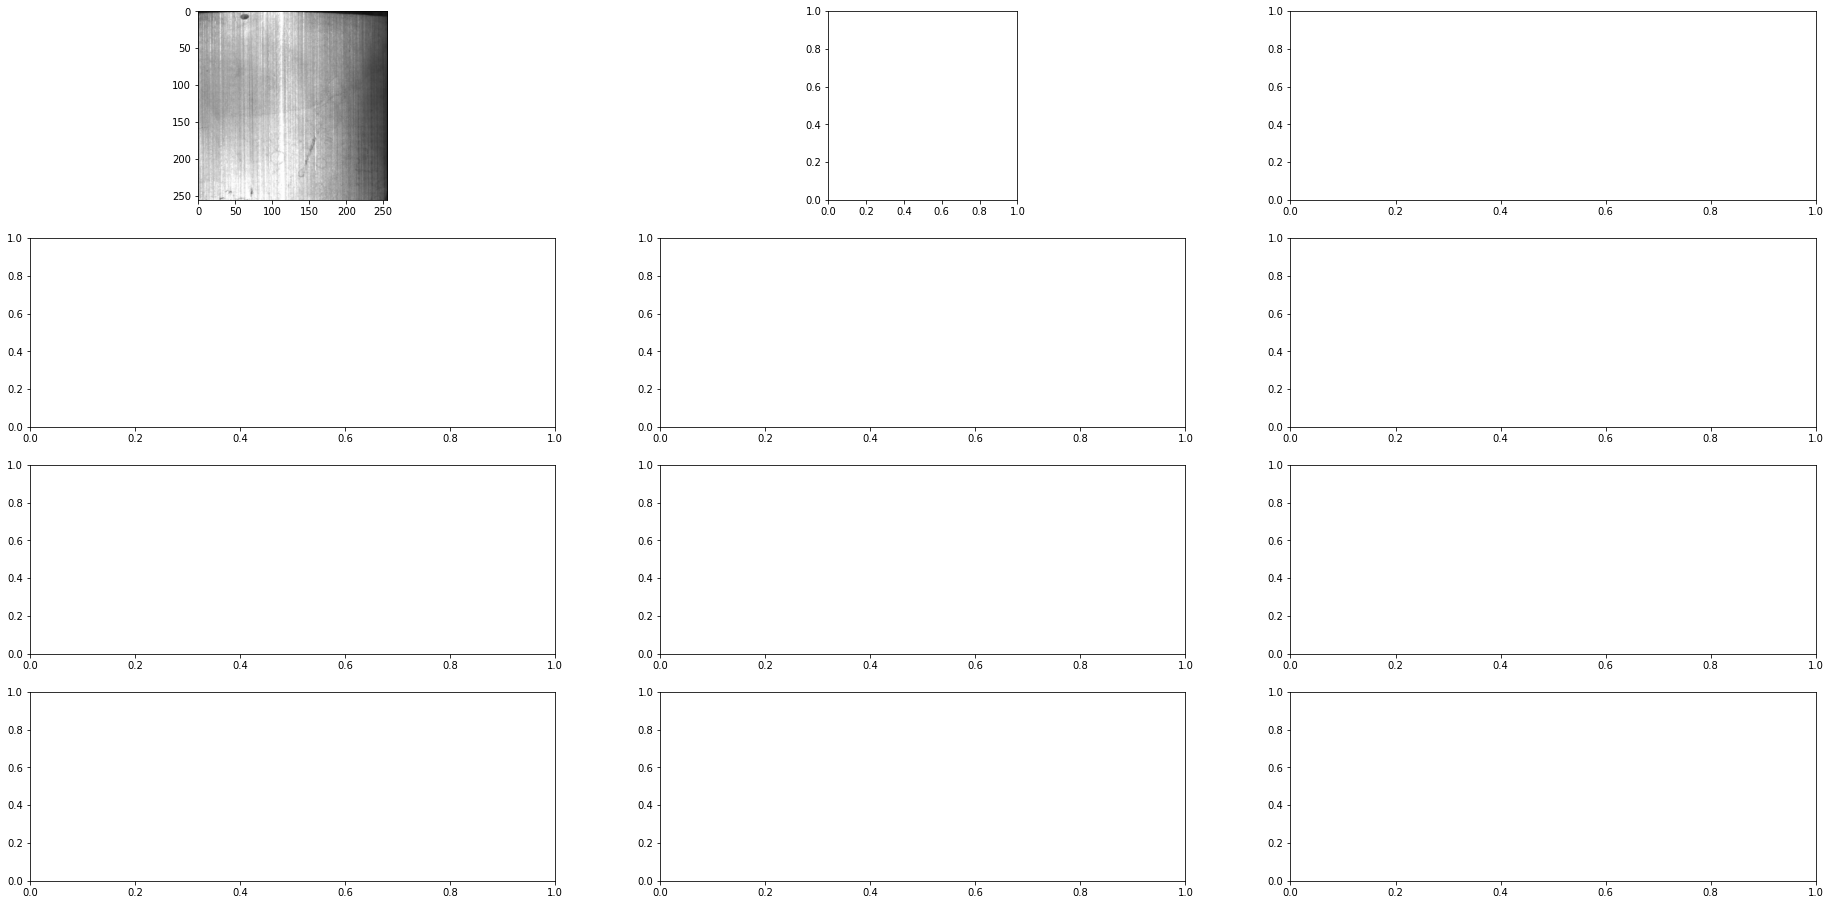

In [17]:
model = get_model(num_classes)
model = model.to(torch.device("cuda"))

x = torch.randn(size=(1, 3, 256, 256), dtype=torch.float32).cuda()
with torch.no_grad():
    out = model(x)

print(f'Shape out net: {out.shape} ')

if SHOW_SUMMARY:
    summary(model, (3, 256, 256))

if TRAIN_NET:
    num_epochs = 100
    initial_lr = 0.001
    criterion = nn.BCELoss()  # Binary cross-entropy
    optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1 - (1 / num_epochs))

    start_time = time.time()
    current_date_hour = datetime.datetime.now()
    new_dir = f"{current_date_hour.year}{current_date_hour.month}{current_date_hour.day}-" \
              f"{current_date_hour.hour}{current_date_hour.minute}{current_date_hour.second}"

    try:
        # Training model
        loss_train, loss_valid, accuracy_valid, IoU_valid, epochs = training_loop(model=model,
                                                                                  num_epochs=num_epochs,
                                                                                  optimizer=optimizer,
                                                                                  lr_scheduler=lr_scheduler,
                                                                                  loss_fn=criterion,
                                                                                  training_loader=training_loader,
                                                                                  validation_loader=validation_loader,
                                                                                  directory=new_dir)
        end_time = time.time()
        print(f"** Training time: {round(((end_time - start_time) / 60), 3)} minutes **\n\n")

        # Show loss and accuracy
        plot_history(loss_train=loss_train, loss_valid=loss_valid, accuracy_valid=accuracy_valid, IoU_valid=IoU_valid,
                     num_epochs=epochs)

    except Exception as e:
        with open(PARENT_MODELS_DIR + "/" + new_dir + "/log/log.txt", 'a') as f:
            f.write(f'\nException: {e}\n\n')

        print(f"Error: {e}")


Risultati ottenuti

100%|██████████| 3/3 [00:01<00:00,  2.27it/s]



############### Test Loss: 0.6330932776133219, Test Acc: 99.66672261555989, Test IOU: 1.1535919230575055e-15 ###############


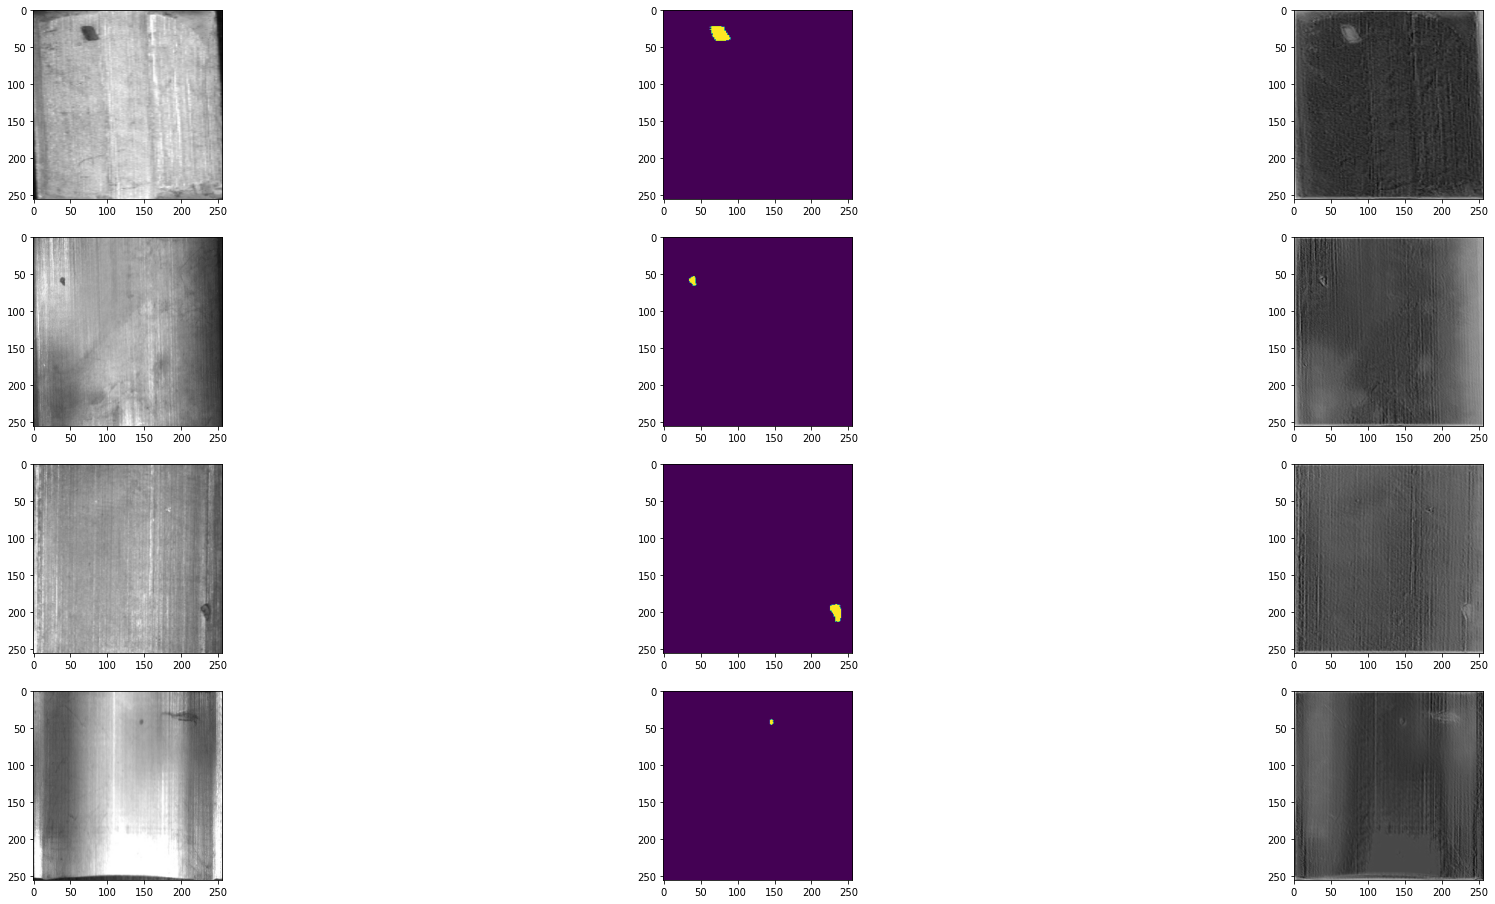

In [24]:
# Test
test_images, test_masks, test_predicted = testing_net(test_loader=test_loader, model=model, loss_fn=criterion)
plot_test_results(test_images, test_masks, test_predicted, 4)